In [25]:
# Enze Xu
# Github: https://github.com/EnzeXu/PINN
# git clone https://github.com/EnzeXu/PINN.git

import torch
import time
import random
import argparse
import math
import os
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from tqdm import tqdm
from collections import OrderedDict
from torchsummary import summary
from torch.backends import cudnn

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
class ConfigSIS:
    T = 100.0
    T_unit = 0.01
    N = int(T / T_unit)
    S_start = 99.0
    I_start = 1.0
    R_start = 0.0
    SIR_sum = 1000.0
    beta = 0.01
    gamma = 0.05
    ub = T
    lb = 0.0

class SimpleNetworkSIS(nn.Module):
    def __init__(self, config):
        super(SimpleNetworkSIS, self).__init__()
        self.setup_seed(0)
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.x, self.y0, self.t0 = None, None, None
        self.generate_x()
        # self.optimizer = optim.LBFGS(self.parameters(), lr=0.001, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100, line_search_fn=None)
        self.initial_start()
        self.model_name = "SimpleNetworkSIS"
        self.sig = nn.Tanh()
        self.fc1 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, 100),
            'sig1': self.sig,
            'lin2': nn.Linear(100, 100),
            'sig2': self.sig,
            'lin3': nn.Linear(100, 100),
            'sig3': self.sig,
            'lin4': nn.Linear(100, 100),
            'sig4': self.sig,
            'lin5': nn.Linear(100, 1),
            # 'sig5': self.sig,
        }))

        self.fc2 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, 100),
            'sig1': self.sig,
            'lin2': nn.Linear(100, 100),
            'sig2': self.sig,
            'lin3': nn.Linear(100, 100),
            'sig3': self.sig,
            'lin4': nn.Linear(100, 100),
            'sig4': self.sig,
            'lin5': nn.Linear(100, 1),
            # 'sig5': self.sig,
        }))

        self.fc3 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, 100),
            'sig1': self.sig,
            'lin2': nn.Linear(100, 100),
            'sig2': self.sig,
            'lin3': nn.Linear(100, 100),
            'sig3': self.sig,
            'lin4': nn.Linear(100, 100),
            'sig4': self.sig,
            'lin5': nn.Linear(100, 1),
            # 'sig5': self.sig,
        }))

    def forward(self, inputs):
        s_old, i_old, r_old = torch.chunk(inputs, 3, 1)
        s_new = self.fc1(s_old)
        i_new = self.fc2(i_old)
        r_new = self.fc2(r_old)
        outputs = torch.cat((s_new, i_new, r_new), 1)
        return outputs

    def generate_x(self):
        # lb_row = np.repeat(self.config.lb, 2).reshape([1, -1])
        # ub_row = np.repeat(self.config.ub, 2).reshape([1, -1])
        # x = lb_row + (ub_row - lb_row) * lhs(1, self.config.N)
        # x = sorted(x, key=lambda xx: xx[0])
        x = [[i*self.config.T_unit, i*self.config.T_unit, i*self.config.T_unit] for i in range(self.config.N)]  # toy
        x = np.asarray(x)
        x = self.encode_t(x)
        self.x = torch.Tensor(x).float().to(self.device)

    def initial_start(self):
        self.t0 = torch.Tensor(np.asarray([-1.0, -1.0, -1.0]).reshape([1, -1])).float().to(self.device)
        self.y0 = torch.Tensor(np.asarray([self.config.S_start, self.config.I_start, self.config.R_start]).reshape([1, -1])).float().to(self.device)
        self.tend = torch.Tensor(np.asarray([1.0, 1.0, 1.0]).reshape([1, -1])).float().to(self.device)

    def loss(self):
        y = self.forward(self.x)
        # print("y.shape:", y[:, 0:1].shape)
        # print(y[:, 0:1])
        # print("self.x.shape:", self.x[:, 0:1].shape)
        # y_t = torch.gradient(y, spacing=(self.x,))[0]  # y_t = tf.gradients(y, t)[0]
        s = y[:, 0:1]
        i = y[:, 1:2]
        r = y[:, 2:3]

        s_t = torch.gradient(y[:, 0:1].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0]
        i_t = torch.gradient(y[:, 1:2].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 1:2].reshape([self.config.N]),))[0]
        r_t = torch.gradient(y[:, 2:3].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 1:2].reshape([self.config.N]),))[0]

        s_t = s_t.reshape([self.config.N, 1])
        i_t = i_t.reshape([self.config.N, 1])
        r_t = r_t.reshape([self.config.N, 1])
        # print(y_t,u_t)
        f_s = s_t - (- self.config.beta * s * i)
        f_i = i_t - (self.config.beta * s * i - self.config.gamma * i)
        f_r = r_t - (self.config.gamma * i)
        # f_u = u_t - (self.config.alpha - self.config.gamma * v) * u
        # f_v = v_t - (-self.config.beta + self.config.e * self.config.gamma * u) * v
        # f_u = u_t - torch.cos(self.decode_t(self.x)[:, 0:1])  # toy
        # f_v = v_t - torch.cos(self.decode_t(self.x)[:, 1:2])  # toy
        f_y = torch.cat((f_s, f_i, f_r), 1)
        y0_pred = self.forward(self.t0)
        yend_pred = self.forward(self.tend)
        # print_flag = False  # True # False
        # if print_flag:
        #     print("u=", u.shape, u, "v=", v.shape, v, "t=", (self.decode_t(self.x)[:, 0:1]).shape, self.decode_t(self.x)[:, 0:1])
        #     print("u_t=", u_t, "shape=", u_t.shape, "u_t_minus=", (self.config.alpha - self.config.gamma * v) * u,
        #           "shape=", ((self.config.alpha - self.config.gamma * v) * u).shape)
        #     print("v_t=", v_t, "shape=", v_t.shape, "v_t_minus=",
        #           (-self.config.beta + self.config.e * self.config.gamma * u) * v, "shape=",
        #           ((-self.config.beta + self.config.e * self.config.gamma * u) * v).shape)
        #     print("self.t0 =", self.t0, "self.t0=", self.t0, "self.y0 =", self.y0,
        #           "y0_pred =", y0_pred, "self.y0 - y0_pred =", self.y0 - y0_pred)

        # loss_2_weights = [[i, i] for i in range(20000)]  # toy
        # loss_2_weights = np.asarray(loss_2_weights)
        # loss_2_weights = torch.Tensor(loss_2_weights).float().to(self.device)

        loss_1 = torch.mean(torch.square(self.y0 - y0_pred))
        loss_2 = torch.mean(torch.square(f_y))  # + torch.var(torch.square(f_y))
        # loss_3 = torch.mean(torch.square(1/(u*u+v*v)))
        # loss_3 = torch.mean(torch.square(1.0 / u - (self.config.e * self.config.gamma / self.config.beta))) + \
        #     torch.mean(torch.square(1.0 / v - (self.config.gamma / self.config.alpha)))
        # loss_3 = 10 * (torch.abs(torch.sum(y0_pred) - self.config.SIR_sum) + torch.abs(torch.sum(yend_pred) - self.config.SIR_sum))
        loss = loss_1 + loss_2
        # if loss < 2.0:
        #     f_y_square_pure = torch.square(f_y).cpu().detach().numpy()
        #     for i in range(20000):
        #         print(i, f_y_square_pure[i])

        return loss, [loss_1, loss_2]
        # return torch.mean(torch.square(y_hat - y))
        # return F.mse_loss(torch.cat((u_hat, v_hat), 1), torch.cat((u, v), 1))
        # return torch.abs(u_hat - u) + torch.abs(v_hat - v)  # F.mse_loss(x_hat, x) + beta * self.kl_div(rho)


    def encode_t(self, num):
        return (num - self.config.lb) / (self.config.ub - self.config.lb) * 2.0 - 1.0

    def decode_t(self, num):
        return self.config.lb + (num + 1.0) / 2.0 * (self.config.ub - self.config.lb)

    @staticmethod
    def setup_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        cudnn.deterministic = True

In [29]:
def get_now_string():
    return time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime(time.time()))

def train_sis(model, args, config, now_string):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model.train()
    model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_last.pt"
    model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_best.pt"
    print("using " + str(device))
    print("epoch = {}".format(args.epoch))
    print("epoch_step = {}".format(args.epoch_step))
    print("model_name = {}".format(model.model_name))
    print("now_string = {}".format(now_string))
    print("model_save_path_last = {}".format(model_save_path_last))
    print("model_save_path_best = {}".format(model_save_path_best))
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    # optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100,
    #       line_search_fn=None)
    epoch_step = args.epoch_step
    start_time = time.time()
    for epoch in range(1, args.epoch + 1):
        optimizer.zero_grad()
        inputs = model.x
        outputs = model(inputs)
        # u_hat, v_hat = torch.chunk(outputs, 2, 1)
        loss, loss_list = model.loss()
        loss_1, loss_2, = loss_list[0], loss_list[1]
        loss.backward()
        optimizer.step()
        best_loss = 999999
        if epoch % epoch_step == 0:
            print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Time:{5:.6f}s".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), time.time() - start_time))
            start_time = time.time()
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_last)
            # print(inputs.shape)
            if loss.item() < best_loss:
                torch.save(
                    {
                        'epoch': args.epoch,
                        'model_state_dict': model.state_dict(),
                        # 'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item()
                    }, model_save_path_best)
        if epoch % args.save_step == 0:
            test_sis(model, args, config, now_string, True)

def test_sis(model, args, config, now_string, show_flag=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model_save_path = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_last.pt"
    model.load_state_dict(torch.load(model_save_path, map_location=device)["model_state_dict"])
    model.eval()
    print("Testing & drawing...")
    t = model.x
    y = model(t)
    y0_pred = model(model.t0)
    # print("t=", t)
    # print("t0=", model.t0)
    # print("y=", y)
    # print("y0_pred=", y0_pred)
    s, i, r = torch.chunk(y, 3, 1)
    # print("u=", u)
    # print("v=", v)
    s = [item[0] for item in s.cpu().detach().numpy()]
    i = [item[0] for item in i.cpu().detach().numpy()]
    r = [item[0] for item in r.cpu().detach().numpy()]
    x = [item[0] for item in model.decode_t(t).cpu().detach().numpy()]
    pairs = [[ss, ii, rr, xx] for ss, ii, rr, xx in zip(s, i, r, x)]
    pairs.sort(key=lambda xx: xx[-1])
    s = [item[0] for item in pairs]
    i = [item[1] for item in pairs]
    r = [item[2] for item in pairs]
    x = [item[3] for item in pairs]
    print("s=", s[:10], "...", s[-10:])
    print("i=", i[:10], "...", i[-10:])
    print("r=", r[:10], "...", r[-10:])
    print("x=", x[:10], "...", x[-10:])
    plt.plot(x, s, marker='.', markersize=0.2, linewidth=0.1, c="b")
    plt.plot(x, i, marker='.', markersize=0.2, linewidth=0.1, c="r")
    plt.plot(x, r, marker='.', markersize=0.2, linewidth=0.1, c="g")
    figure_save_path = f"{args.main_path}/figure/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_{int(time.time())}.png"
    plt.savefig(figure_save_path, dpi=300)
    if show_flag:
        plt.show()
    plt.clf()
    print("Saved as {}".format(figure_save_path))

class Args:
  epoch = 2000
  epoch_step = 100
  lr = 0.001
  main_path = "."
  save_step = 500

def run_sis(main_path=None):
    # parser = argparse.ArgumentParser()
    # parser.add_argument("--epoch", type=int, default=1000, help="epoch")
    # parser.add_argument("--epoch_step", type=int, default=10, help="epoch_step")
    # parser.add_argument('--lr', type=float, default=0.01, help='learning rate, default=0.001')
    # parser.add_argument("--main_path", default=".", help="main_path")
    # parser.add_argument("--save_step", type=int, default=100, help="save_step")
    # args = parser.parse_args()
    args = Args
    if main_path:
        args.main_path = main_path
    if not os.path.exists("{}/train".format(args.main_path)):
        os.makedirs("{}/train".format(args.main_path))
    if not os.path.exists("{}/figure".format(args.main_path)):
        os.makedirs("{}/figure".format(args.main_path))
    now_string = get_now_string()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    config = ConfigSIS
    model = SimpleNetworkSIS(config).to(device)
    train_sis(model, args, config, now_string)
    model = SimpleNetworkSIS(config).to(device)
    test_sis(model, args, config, now_string)

using cuda
epoch = 2000
epoch_step = 100
model_name = SimpleNetworkSIS
now_string = 2022-03-26-21-48-26
model_save_path_last = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkSIS_2000_100_0.001_0.01_0.05_2022-03-26-21-48-26_last.pt
model_save_path_best = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkSIS_2000_100_0.001_0.01_0.05_2022-03-26-21-48-26_best.pt
Epoch [00100/02000] Loss:2307.187500 Loss_1:2307.181396 Loss_2:0.006146 Time:0.882669s
Epoch [00200/02000] Loss:1791.797729 Loss_1:1791.794800 Loss_2:0.002944 Time:0.878025s
Epoch [00300/02000] Loss:1377.424683 Loss_1:1377.422729 Loss_2:0.001963 Time:0.864983s
Epoch [00400/02000] Loss:1043.416504 Loss_1:1043.414551 Loss_2:0.001913 Time:0.869811s
Epoch [00500/02000] Loss:776.999207 Loss_1:776.997437 Loss_2:0.001748 Time:0.873831s
Testing & drawing...
s= [50.79822, 50.79822, 50.79822, 50.79822, 50.79822, 50.79822, 50.79822, 50.79822, 50.79822, 50.79822] ... [50.33517, 50.33404, 50.3329, 50.331764, 50.330616, 50.329

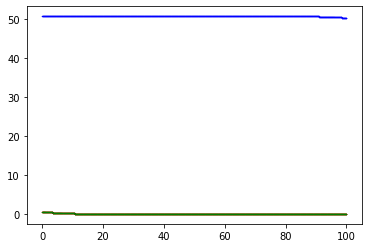

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkSIS_2000_100_0.001_0.01_0.05_2022-03-26-21-48-26_1648331311.png
Epoch [00600/02000] Loss:567.673523 Loss_1:567.671448 Loss_2:0.002062 Time:1.352929s
Epoch [00700/02000] Loss:406.141602 Loss_1:406.139526 Loss_2:0.002090 Time:0.867618s
Epoch [00800/02000] Loss:284.019318 Loss_1:284.017120 Loss_2:0.002182 Time:0.865815s
Epoch [00900/02000] Loss:193.775040 Loss_1:193.772690 Loss_2:0.002355 Time:0.895014s
Epoch [01000/02000] Loss:128.742340 Loss_1:128.740036 Loss_2:0.002310 Time:0.912048s
Testing & drawing...
s= [79.401764, 79.401764, 79.401764, 79.401764, 79.401764, 79.401764, 79.401764, 79.401764, 79.401764, 79.401764] ... [79.179634, 79.17906, 79.178505, 79.177925, 79.17736, 79.17679, 79.17621, 79.17565, 79.17506, 79.174484]
i= [0.49248332, 0.49104512, 0.4896075, 0.4881717, 0.4867366, 0.48530316, 0.48387045, 0.48243952, 0.4810093, 0.47958088] ... [0.009981163, 0.009983815, 0.009986311, 0.009988882, 0.009991445, 0.0099940

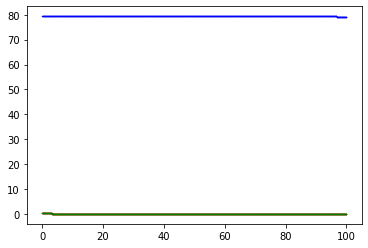

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkSIS_2000_100_0.001_0.01_0.05_2022-03-26-21-48-26_1648331316.png
Epoch [01100/02000] Loss:83.144188 Loss_1:83.141884 Loss_2:0.002302 Time:1.359775s
Epoch [01200/02000] Loss:52.105862 Loss_1:52.103470 Loss_2:0.002391 Time:0.919309s
Epoch [01300/02000] Loss:31.639448 Loss_1:31.637074 Loss_2:0.002374 Time:0.887440s
Epoch [01400/02000] Loss:18.593847 Loss_1:18.591480 Loss_2:0.002366 Time:0.862136s
Epoch [01500/02000] Loss:10.572172 Loss_1:10.569731 Loss_2:0.002442 Time:0.869433s
Testing & drawing...
s= [93.42997, 93.42997, 93.42997, 93.42997, 93.42997, 93.42997, 93.42997, 93.42997, 93.42997, 93.42997] ... [93.26569, 93.26528, 93.264854, 93.26442, 93.26401, 93.26358, 93.26315, 93.26273, 93.2623, 93.26188]
i= [0.49183685, 0.48958886, 0.4873426, 0.4850996, 0.48285842, 0.48062056, 0.47838485, 0.47615248, 0.4739223, 0.47169566] ... [0.0072293803, 0.007230319, 0.007231362, 0.007232301, 0.007233277, 0.0072342083, 0.0072351918, 0.0

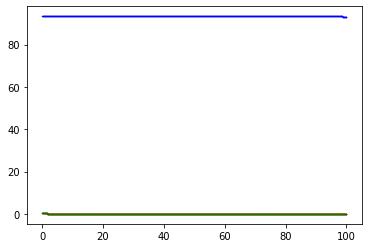

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkSIS_2000_100_0.001_0.01_0.05_2022-03-26-21-48-26_1648331321.png
Epoch [01600/02000] Loss:5.823030 Loss_1:5.820615 Loss_2:0.002416 Time:1.357243s
Epoch [01700/02000] Loss:3.121256 Loss_1:3.118848 Loss_2:0.002408 Time:0.875767s
Epoch [01800/02000] Loss:1.647112 Loss_1:1.644656 Loss_2:0.002455 Time:0.894207s
Epoch [01900/02000] Loss:0.877160 Loss_1:0.874738 Loss_2:0.002423 Time:0.904018s
Epoch [02000/02000] Loss:0.493146 Loss_1:0.490564 Loss_2:0.002583 Time:0.872909s
Testing & drawing...
s= [98.01829, 98.01829, 98.01829, 98.01829, 98.01829, 98.01829, 98.01829, 98.01829, 98.01829, 98.01829] ... [97.884766, 97.884445, 97.8841, 97.88377, 97.88343, 97.883095, 97.88275, 97.882416, 97.88207, 97.88174]
i= [0.4699705, 0.46687302, 0.46378294, 0.46070197, 0.45762846, 0.45456436, 0.4515082, 0.4484615, 0.44542292, 0.44239435] ... [-0.0032747164, -0.0032751635, -0.0032755956, -0.0032761171, -0.0032764897, -0.0032769218, -0.0032774433,

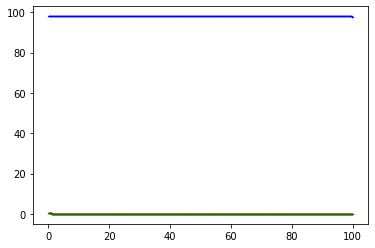

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkSIS_2000_100_0.001_0.01_0.05_2022-03-26-21-48-26_1648331326.png
Testing & drawing...
s= [98.01829, 98.01829, 98.01829, 98.01829, 98.01829, 98.01829, 98.01829, 98.01829, 98.01829, 98.01829] ... [97.884766, 97.884445, 97.8841, 97.88377, 97.88343, 97.883095, 97.88275, 97.882416, 97.88207, 97.88174]
i= [0.4699705, 0.46687302, 0.46378294, 0.46070197, 0.45762846, 0.45456436, 0.4515082, 0.4484615, 0.44542292, 0.44239435] ... [-0.0032747164, -0.0032751635, -0.0032755956, -0.0032761171, -0.0032764897, -0.0032769218, -0.0032774433, -0.0032779798, -0.0032784566, -0.0032788739]
r= [0.4699705, 0.46687302, 0.46378294, 0.46070197, 0.45762846, 0.45456436, 0.4515082, 0.4484615, 0.44542292, 0.44239435] ... [-0.0032747164, -0.0032751635, -0.0032755956, -0.0032761171, -0.0032764897, -0.0032769218, -0.0032774433, -0.0032779798, -0.0032784566, -0.0032788739]
x= [0.0, 0.009998679, 0.020000339, 0.029999018, 0.040000677, 0.049999356, 0.0600010

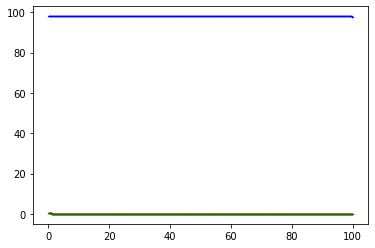

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkSIS_2000_100_0.001_0.01_0.05_2022-03-26-21-48-26_1648331326.png


<Figure size 432x288 with 0 Axes>

In [30]:
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_sis(main_path)